In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import norm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Simple Simulation

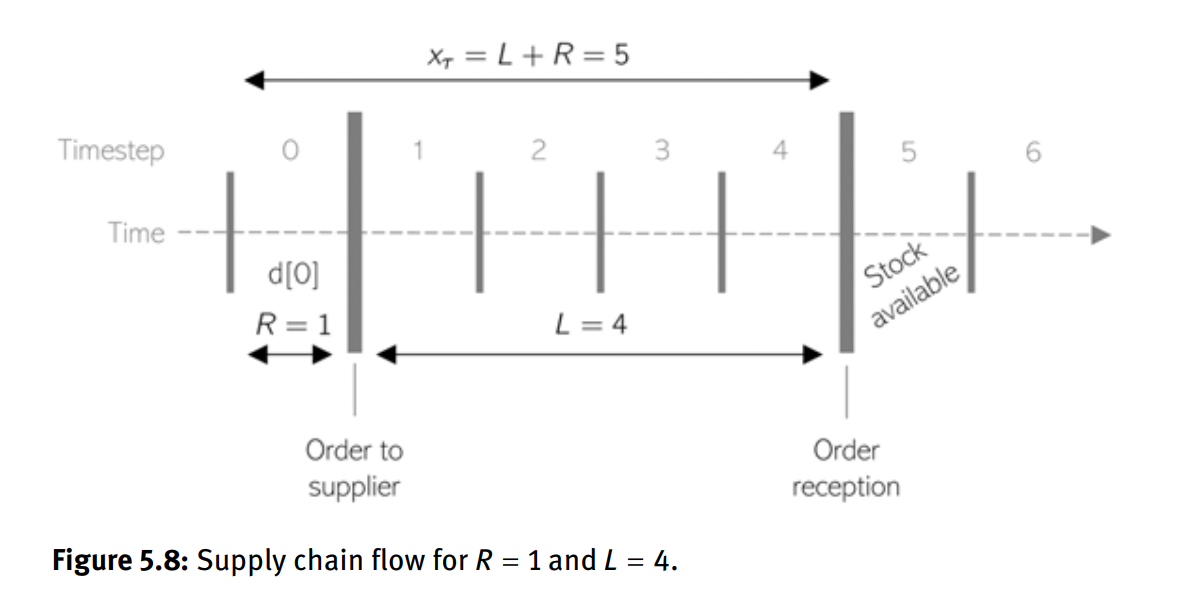

In [2]:
time = 200
demand_mean = 100 # define average demand
demand_std = 25 # define the standard deviation demand
d = np.maximum(np.random.normal(demand_mean,demand_std,time).round(0).astype(int),0)

# Other variables
L, R, alpha = 4,1,0.95
z = norm.ppf(alpha)

x_std = np.sqrt(R+L)*demand_std # risk period standard deviation

safety_stock = np.round(z*x_std,1) # calculate the safety stock

cycle_stock = 0.5 * demand_mean * R

in_transit_stock = demand_mean*L

S = safety_stock + 2*cycle_stock + in_transit_stock # up-to-level in fixed period length policy

In [3]:
# Define the on-hand and in-transit inventory
on_hand = np.zeros(time,dtype=int)
transit = np.zeros((time,L+1),dtype=int)

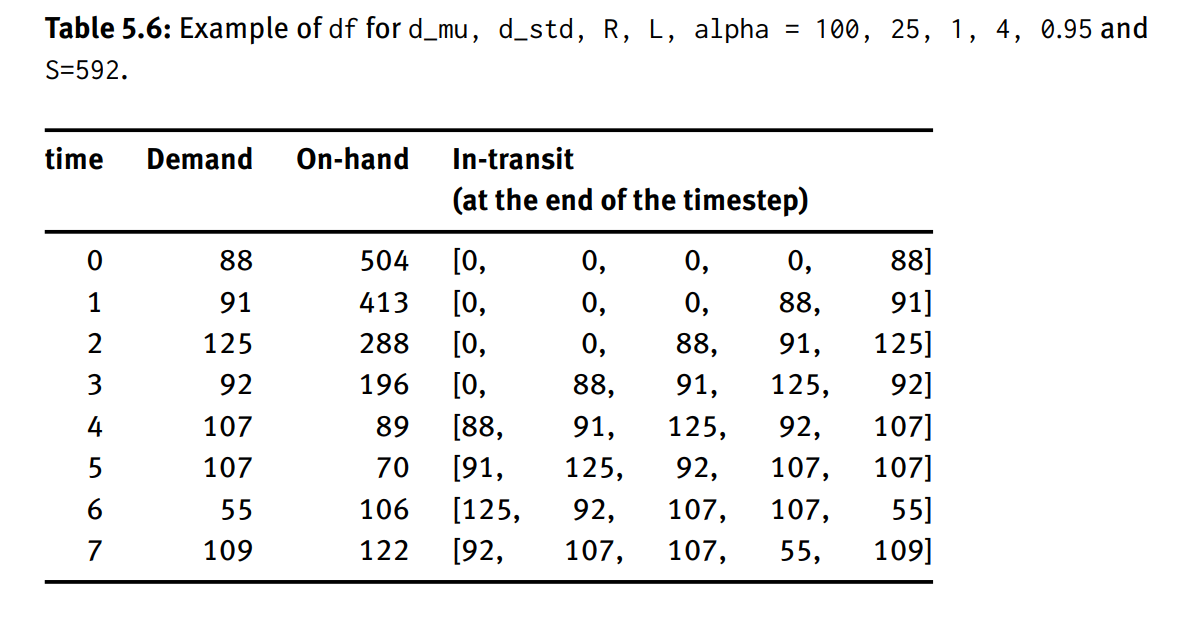

In [4]:
on_hand[0] = S - d[0]

transit[1,-1] = d[0]

# Safety Stock in Stochastic Lead Time and Demand

In [5]:
# Define the demand and lead time
L, L_std = 4,1

x_std = 20

## Normal Loss Function

In [6]:
def normal_loss_func(phi_risk,mean_risk,inv_level):
    result = (phi_risk**2)*norm.pdf(inv_level,mean_risk,phi_risk) + (mean_risk - inv_level)*(1-norm.cdf(inv_level,mean_risk,phi_risk))
    return result


In [7]:
inv = 270
mean = 250
phi_risk = 30

normal_loss_func(phi_risk=phi_risk, mean_risk=mean, inv_level=inv)


4.53358941473211

This mean the unit short you will face excess demand is 4.53 units

In [8]:
def normal_loss_standard(x):
    result = norm.pdf(x) - x*(1 - norm.cdf(x))
    return result


In [9]:
phi_risk*normal_loss_standard(((inv-mean)/phi_risk))

4.533589414732109

# Cost and Service Optimization

Choose the service cycle level to achieve one metric: profit


# (R,S) Policy

- Optimize the review period: simulate to find the review period to minimize cost

- Optimize service level => đạo hàm cost function to find which function for z to has minimum cost

In [10]:
def normal_standard_loss(x):
    return norm.pdf(x) - x*(1-norm.cdf(x))

def cost(h,d,R,z,x_std,k,b):
    return h*((d*R)/2+z*x_std) + k/R + (b*x_std*normal_standard_loss(z))/R 


In [11]:
d = 100
x_std = np.sqrt(1+1)*25
h = 1.25
b = 50
k = 1000
Review_period = 1
Lead_time = 1
alpha = 0.95
z=norm.ppf(alpha) # mean 95% cycle service level

cost(h,d,Review_period,z,x_std,k,b)

1172.1268296238134

## Optimal cycle service level

In [12]:
# define the optimal a
def CSL_optimal(h,R,b):
    return 1 - (h*R)/b



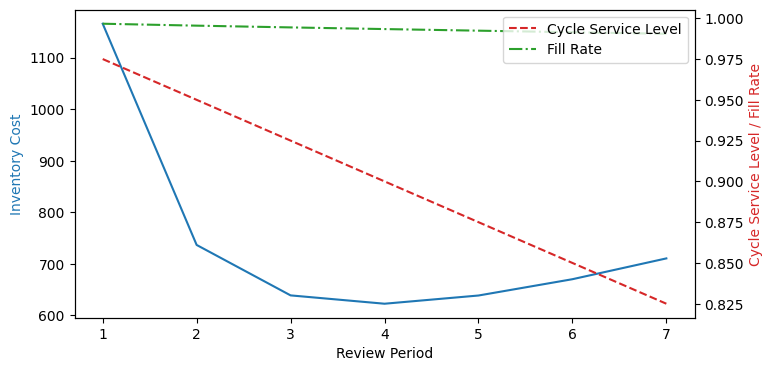

In [13]:
# create a dataframe for simulation
df = pd.DataFrame(
    columns=['Review Period','Inventory Cost', 'Cycle Service Level', 'Fill Rate']
)


for R in [1,2,3,4,5,6,7]:
    d = 100
    h = 1.25
    b = 50
    k = 1000
    Review_period = 1
    x_std = 25*np.sqrt(Lead_time+R)
    alpha = CSL_optimal(h,R,b)
    z = norm.ppf(alpha)
    beta = 1 - x_std*normal_standard_loss(z) / R / d
    df.loc[len(df)] = [R,cost(h, d, R, z, x_std, k, b), alpha, beta]

# Create a figure and two subplots
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot the primary y-axis data (Inventory Cost)
ax1.set_xlabel('Review Period')
ax1.set_ylabel('Inventory Cost', color='tab:blue')
ax1.plot(df['Review Period'], df['Inventory Cost'], color='tab:blue')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the secondary y-axis data (Cycle Service Level and Fill Rate)
ax2.set_ylabel('Cycle Service Level / Fill Rate', color='tab:red')
ax2.plot(df['Review Period'], df['Cycle Service Level'], color='tab:red', linestyle='--', label='Cycle Service Level')
ax2.plot(df['Review Period'], df['Fill Rate'], color='tab:green', linestyle='-.', label='Fill Rate')

# Display a legend for the secondary y-axis
ax2.legend(loc='upper right')

# Show the combined plot
plt.show()

Best Review Period length is 4 week with the smallest total cost and cycle service level is 90%

## (s,Q) policy

- Optimize service level: like (R,S) policy

- Optimize Q - order quantity: based on the EOQ + add the expected backorder

- Optimize Q and service level: use the while loop to find Q => z => Q ... and stop when it has the lowest cost

In [14]:
# definition for loss function in backorder units
def normal_standard_loss(x):
    return norm.pdf(x) - x*(1-norm.cdf(x))

# definition for order quantity with EOQ function
def EOQ(k,D,h):
    return np.sqrt((2*k*D)/h)

# definition for cycle service level optimization
def CSL_optimal(h,Q,D,b):
    return 1-(h*Q)/(b*D)

# definition for quantity optimal
def Q_optimal(k,D,h,b,z,x_std):
    return np.sqrt(2*(k+b*x_std*normal_standard_loss(z))*D/h)



In [15]:
# Create z and Q optimal definition in loop
def sQ_optimal(k,D,h,b,x_std):
    Q = EOQ(k,D,h)
    Q_old = 0
    while Q_old != Q:
        Q_old = Q
        z_new = np.round(norm.ppf(CSL_optimal(h,Q,D,b)),3)
        Q = round(Q_optimal(k,D,h,b,z_new,x_std))
    print(f'The optimal quantity order = {Q} units')
    print(f'The optimal cycle service level is = {z_new}')
    return z_new,Q

In [16]:
# Define the example
k = 1000
D = 100*52
h = 1.25*52
b = 50 
x_std = 25

sQ_optimal(k,D,h,b,x_std)

The optimal quantity order = 412 units
The optimal cycle service level is = 1.265


(1.265, 412)

z = 1.265 => service level equal ~ 89.7%

Q* = 412 units

# Beyond Normality

What if our model isn't normal distribution?

In [17]:
def get_data(car_maker):
    df = pd.read_csv('norway_new_car_sales_by_make1.csv')
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + df['Month'].astype(str),format="%Y%m")
    df = (
        df.loc[df['Make'] == car_maker, ['Date','Quantity']].rename(
            columns={'Quantity':'Sales'}
        ).set_index('Date')
    )
    return df

In [18]:
df = get_data('Ford')
df.head(10)

,Sales
Date,
2007-01-01,870
2007-02-01,686
2007-03-01,766
2007-04-01,451
2007-05-01,648
2007-06-01,772
2007-07-01,1006
2007-08-01,816
2007-09-01,679


In [19]:
hist_range = (df['Sales'].min()*0.8, df['Sales'].max()*1.2)

y_actuals, edge = np.histogram(df,bins=30,density=True,range=hist_range)

y_actuals = y_actuals / sum(y_actuals)

print(y_actuals)
print(edge)

[0.         0.         0.00826446 0.04132231 0.03305785 0.07438017
 0.09090909 0.11570248 0.11570248 0.04958678 0.10743802 0.05785124
 0.04132231 0.02479339 0.07438017 0.02479339 0.04132231 0.02479339
 0.00826446 0.02479339 0.01652893 0.00826446 0.00826446 0.00826446
 0.         0.         0.         0.         0.         0.        ]
[ 360.8         405.29333333  449.78666667  494.28        538.77333333
  583.26666667  627.76        672.25333333  716.74666667  761.24
  805.73333333  850.22666667  894.72        939.21333333  983.70666667
 1028.2        1072.69333333 1117.18666667 1161.68       1206.17333333
 1250.66666667 1295.16       1339.65333333 1384.14666667 1428.64
 1473.13333333 1517.62666667 1562.12       1606.61333333 1651.10666667
 1695.6       ]


Dòng mã này dùng để tính toán các điểm trung tâm giữa các giá trị trong mảng 'edge'. Cách thức hoạt động như sau:

np.roll(edge, -1) dịch chuyển mảng 'edge' sang trái một vị trí. Điều này có nghĩa rằng mỗi phần tử được dịch chuyển một vị trí về phía đầu của mảng, và phần tử cuối cùng trở thành phần tử đầu tiên.

edge + np.roll(edge, -1) cộng mảng 'edge' ban đầu với mảng 'edge' sau khi dịch chuyển theo từng phần tử. Kết quả là một mảng mới trong đó mỗi phần tử là tổng của phần tử tương ứng trong mảng 'edge' ban đầu và phần tử đứng sau nó trong mảng đã dịch chuyển. Phần tử cuối cùng trong mảng mới này là tổng của phần tử cuối cùng trong mảng 'edge' ban đầu và phần tử đầu tiên trong mảng 'edge' ban đầu (do việc dịch chuyển).

[:-1] cắt bớt phần tử cuối cùng của mảng kết quả. Điều này là vì phần tử cuối cùng là tổng của phần tử cuối cùng trong mảng 'edge' ban đầu và phần tử đầu tiên trong mảng 'edge' ban đầu, và nó không cần thiết.

Cuối cùng, phép chia cho 2 được thực hiện trên mảng đã cắt, tính toán điểm trung tâm. Điều này chia mỗi phần tử cho 2 để lấy điểm giữa giữa mỗi cặp giá trị liền kề.

Tóm lại, đoạn mã này tính toán các điểm trung tâm giữa các giá trị liền kề trong mảng 'edge', điều này hữu ích cho nhiều ứng dụng khác nhau, chẳng hạn như tạo các ngăn cho biểu đồ tần số hoặc xác định vị trí của các điểm dữ liệu giữa các giá trị rời rạc.

In [20]:
# roll the edge to find center
center = (edge + np.roll(edge,-1))[:-1] / 2 

center

array([ 383.04666667,  427.54      ,  472.03333333,  516.52666667,
        561.02      ,  605.51333333,  650.00666667,  694.5       ,
        738.99333333,  783.48666667,  827.98      ,  872.47333333,
        916.96666667,  961.46      , 1005.95333333, 1050.44666667,
       1094.94      , 1139.43333333, 1183.92666667, 1228.42      ,
       1272.91333333, 1317.40666667, 1361.9       , 1406.39333333,
       1450.88666667, 1495.38      , 1539.87333333, 1584.36666667,
       1628.86      , 1673.35333333])

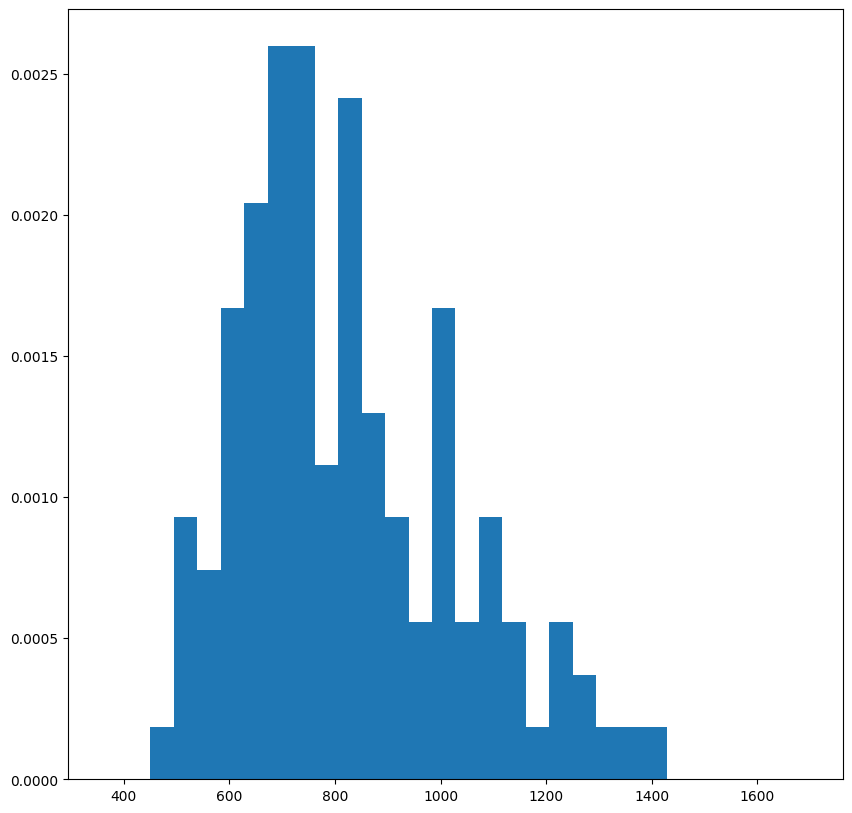

In [21]:
plt.figure(figsize=(10,10))

plt.hist(
    df['Sales'].values,
    bins = 30,
    density=True,
    label='Sales',
    range=hist_range
)

plt.show()

